In [1]:
import lightning as L
import torch
from torch import optim, nn
import torch.nn.functional as F
import torch.utils.data as data
from torchvision.datasets import MNIST
from torchvision.utils import make_grid
import torchvision.transforms as transforms
from torchmetrics import functional as mF
import matplotlib.pyplot as plt

/home/nicolas/mambaforge/envs/gom/lib/python3.11/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/home/nicolas/mambaforge/envs/gom/lib/python3.11/site-packages/torchvision/image.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


### Define the baseline

Simple MLP with 64 hidden dimensions.

In [2]:
class MNISTDataset(MNIST):
    pass

class DigitDataModule(L.LightningDataModule):
    # TAKEN FROM https://github.com/sxg/PyTorch-Lightning-MNIST-Classifier/blob/main/DigitDataModule.py
    def __init__(self, dataset, batch_size=64):
        super().__init__()
        self.batch_size = batch_size
        self.dataset = dataset
        self.transform = transforms.Compose([
          transforms.ToTensor(),
          transforms.Normalize((0.5,), (0.5,))])

    def prepare_data(self):
        self.dataset("MNIST", train=True, download=True)
        self.dataset("MNIST", train=False, download=True)

    def setup(self, stage):
        if stage == "fit":
            full_set = self.dataset(
                root="MNIST",
                train=True,
                transform=self.transform,
            )
            train_set_size = int(len(full_set) * 0.8)
            val_set_size = len(full_set) - train_set_size
            seed = torch.Generator().manual_seed(42)
            (
                self.train_set,
                self.val_set,
            ) = data.random_split(  # Split train/val datasets
                full_set, [train_set_size, val_set_size], generator=seed
            )
        elif stage == "test":
            self.test_set = self.dataset(
                root="MNIST",
                train=False,
                transform=self.transform,
            )

    def train_dataloader(self):
        return data.DataLoader(self.train_set, batch_size=self.batch_size, num_workers=16)

    def val_dataloader(self):
        return data.DataLoader(self.val_set, batch_size=self.batch_size, num_workers=16)

    def test_dataloader(self):
        return data.DataLoader(self.test_set, batch_size=self.batch_size, num_workers=16)

class DigitModuleBaseline(L.LightningModule):
    def __init__(self):
        super().__init__()
        self.mlp = nn.Sequential(
            nn.Linear(784, 64),
            nn.ReLU())

        self.classifier = nn.Linear(64, 10)

    def data_step(self, batch, log_name):
        x, y = batch
        
        latent = self.mlp(x.view(-1, 784))
        pred = self.classifier(latent)

        loss = F.cross_entropy(pred, y)
        self.log(f"{log_name}/loss", loss, prog_bar=True)

        acc = mF.accuracy(pred, y, task="multiclass", num_classes=10)
        self.log(f"{log_name}/accuracy", acc, prog_bar=True)

        return pred, loss, acc

    def configure_optimizers(self):
        return optim.Adam(self.parameters(), lr=1e-3)

    def training_step(self, batch, batch_idx):
        pred, loss, _ = self.data_step(batch, "train")
        return loss

    def validation_step(self, batch, batch_idx):
        pred, loss, _ = self.data_step(batch, "valid")
        return loss

    def test_step(self, batch, batch_idx):
        pred, loss, acc = self.data_step(batch, "test")
        return {"loss": loss, "acc": acc}

Train the baseline

In [78]:
dm = DigitDataModule(MNISTDataset, batch_size=64)

model = DigitModuleBaseline()
trainer = L.Trainer(
  devices=[0], 
  accelerator="gpu",
  max_epochs=10, 
  logger=[L.pytorch.loggers.TensorBoardLogger("tb_logs", name="baseline")])

trainer.fit(model, datamodule=dm)
trainer.test(model, datamodule=dm)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name       | Type       | Params
------------------------------------------
0 | mlp        | Sequential | 50.2 K
1 | classifier | Linear     | 650   
------------------------------------------
50.9 K    Trainable params
0         Non-trainable params
50.9 K    Total params
0.204     Total estimated model params size (MB)


Sanity Checking: |                                                                                            …

Training: |                                                                                                   …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

`Trainer.fit` stopped: `max_epochs=10` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Testing: |                                                                                                    …

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x77c392512200>Exception ignored in: 
<function _MultiProcessingDataLoaderIter.__del__ at 0x77c392512200>Traceback (most recent call last):

  File "/home/nicolas/mambaforge/envs/gom/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__
Traceback (most recent call last):
  File "/home/nicolas/mambaforge/envs/gom/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__
        self._shutdown_workers()self._shutdown_workers()

  File "/home/nicolas/mambaforge/envs/gom/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
  File "/home/nicolas/mambaforge/envs/gom/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
Exception ignored in:     Exception ignored in:     <function _MultiProcessingDataLoaderIter.__del__ at 0x77c392512200>if w.is_alive():<function _MultiProcessingDataLoa

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test/accuracy         0.9639000296592712
        test/loss           0.12263163924217224
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test/loss': 0.12263163924217224, 'test/accuracy': 0.9639000296592712}]

## Let's sandra it

In [3]:
from sandra import Ontology, Situation
from sandra.torch import ReasonerModule
from functools import partial

dc = Ontology.from_graph("digital_display.ttl")
reasoner = ReasonerModule(dc, device="cuda:0")

In [4]:
class DescribedMNISTDataset(MNIST):
    def __init__(self, *args, dc=None, reasoner=None, **kwargs):
      super().__init__(*args, **kwargs)
      self.dc = dc
      self.reasoner = reasoner

      self.situation_map = {
        0: torch.zeros(len(self.reasoner.ontology.roles)),
        1: self.reasoner.encode(Situation([
          dc["https://w3id.org/geometryofmeaning/digital-display/SegmentBOn"],
          dc["https://w3id.org/geometryofmeaning/digital-display/SegmentCOn"],
        ])),
        2: self.reasoner.encode(Situation([
          dc["https://w3id.org/geometryofmeaning/digital-display/SegmentAOn"],
          dc["https://w3id.org/geometryofmeaning/digital-display/SegmentBOn"],
          dc["https://w3id.org/geometryofmeaning/digital-display/SegmentDOn"],
          dc["https://w3id.org/geometryofmeaning/digital-display/SegmentEOn"],
          dc["https://w3id.org/geometryofmeaning/digital-display/SegmentGOn"],
        ])),
        3: self.reasoner.encode(Situation([
          dc["https://w3id.org/geometryofmeaning/digital-display/SegmentAOn"],
          dc["https://w3id.org/geometryofmeaning/digital-display/SegmentBOn"],
          dc["https://w3id.org/geometryofmeaning/digital-display/SegmentCOn"],
          dc["https://w3id.org/geometryofmeaning/digital-display/SegmentDOn"],
          dc["https://w3id.org/geometryofmeaning/digital-display/SegmentGOn"],
        ])),
        4: self.reasoner.encode(Situation([
          dc["https://w3id.org/geometryofmeaning/digital-display/SegmentBOn"],
          dc["https://w3id.org/geometryofmeaning/digital-display/SegmentCOn"],
          dc["https://w3id.org/geometryofmeaning/digital-display/SegmentFOn"],
          dc["https://w3id.org/geometryofmeaning/digital-display/SegmentGOn"],
        ])),
        5: self.reasoner.encode(Situation([
          dc["https://w3id.org/geometryofmeaning/digital-display/SegmentAOn"],
          dc["https://w3id.org/geometryofmeaning/digital-display/SegmentCOn"],
          dc["https://w3id.org/geometryofmeaning/digital-display/SegmentDOn"],
          dc["https://w3id.org/geometryofmeaning/digital-display/SegmentFOn"],
          dc["https://w3id.org/geometryofmeaning/digital-display/SegmentGOn"],
        ])),
        6: self.reasoner.encode(Situation([
          dc["https://w3id.org/geometryofmeaning/digital-display/SegmentAOn"],
          dc["https://w3id.org/geometryofmeaning/digital-display/SegmentCOn"],
          dc["https://w3id.org/geometryofmeaning/digital-display/SegmentDOn"],
          dc["https://w3id.org/geometryofmeaning/digital-display/SegmentEOn"],
          dc["https://w3id.org/geometryofmeaning/digital-display/SegmentFOn"],
          dc["https://w3id.org/geometryofmeaning/digital-display/SegmentGOn"],
        ])),
        7: self.reasoner.encode(Situation([
          dc["https://w3id.org/geometryofmeaning/digital-display/SegmentAOn"],
          dc["https://w3id.org/geometryofmeaning/digital-display/SegmentBOn"],
          dc["https://w3id.org/geometryofmeaning/digital-display/SegmentCOn"]
        ])),
        8: self.reasoner.encode(Situation([
          dc["https://w3id.org/geometryofmeaning/digital-display/SegmentAOn"],
          dc["https://w3id.org/geometryofmeaning/digital-display/SegmentBOn"],
          dc["https://w3id.org/geometryofmeaning/digital-display/SegmentCOn"],
          dc["https://w3id.org/geometryofmeaning/digital-display/SegmentDOn"],
          dc["https://w3id.org/geometryofmeaning/digital-display/SegmentEOn"],
          dc["https://w3id.org/geometryofmeaning/digital-display/SegmentFOn"],
          dc["https://w3id.org/geometryofmeaning/digital-display/SegmentGOn"],
        ])),
        9: self.reasoner.encode(Situation([
          dc["https://w3id.org/geometryofmeaning/digital-display/SegmentAOn"],
          dc["https://w3id.org/geometryofmeaning/digital-display/SegmentBOn"],
          dc["https://w3id.org/geometryofmeaning/digital-display/SegmentCOn"],
          dc["https://w3id.org/geometryofmeaning/digital-display/SegmentDOn"],
          dc["https://w3id.org/geometryofmeaning/digital-display/SegmentFOn"],
          dc["https://w3id.org/geometryofmeaning/digital-display/SegmentGOn"],
        ]))
      }

    def __getitem__(self, idx):
        image, label = super().__getitem__(idx)
        return image, self.situation_map[label], label


class DescribedMNISTDatasetWithNegation(MNIST):
    def __init__(self, *args, dc=None, reasoner=None, **kwargs):
      super().__init__(*args, **kwargs)
      self.dc = dc
      self.reasoner = reasoner

      self.situation_map = {
        0: self.reasoner.encode(Situation([
          dc["https://w3id.org/geometryofmeaning/digital-display/SegmentAOff"],
          dc["https://w3id.org/geometryofmeaning/digital-display/SegmentBOff"],
          dc["https://w3id.org/geometryofmeaning/digital-display/SegmentCOff"],
          dc["https://w3id.org/geometryofmeaning/digital-display/SegmentDOff"],
          dc["https://w3id.org/geometryofmeaning/digital-display/SegmentEOff"],
          dc["https://w3id.org/geometryofmeaning/digital-display/SegmentFOff"],
          dc["https://w3id.org/geometryofmeaning/digital-display/SegmentGOff"],
        ])),
        1: self.reasoner.encode(Situation([
          dc["https://w3id.org/geometryofmeaning/digital-display/SegmentAOff"],
          dc["https://w3id.org/geometryofmeaning/digital-display/SegmentBOn"],
          dc["https://w3id.org/geometryofmeaning/digital-display/SegmentCOn"],
          dc["https://w3id.org/geometryofmeaning/digital-display/SegmentDOff"],
          dc["https://w3id.org/geometryofmeaning/digital-display/SegmentEOff"],
          dc["https://w3id.org/geometryofmeaning/digital-display/SegmentFOff"],
          dc["https://w3id.org/geometryofmeaning/digital-display/SegmentGOff"],
        ])),
        2: self.reasoner.encode(Situation([
          dc["https://w3id.org/geometryofmeaning/digital-display/SegmentAOn"],
          dc["https://w3id.org/geometryofmeaning/digital-display/SegmentBOn"],
          dc["https://w3id.org/geometryofmeaning/digital-display/SegmentCOff"],
          dc["https://w3id.org/geometryofmeaning/digital-display/SegmentDOn"],
          dc["https://w3id.org/geometryofmeaning/digital-display/SegmentEOn"],
          dc["https://w3id.org/geometryofmeaning/digital-display/SegmentFOff"],
          dc["https://w3id.org/geometryofmeaning/digital-display/SegmentGOn"],
        ])),
        3: self.reasoner.encode(Situation([
          dc["https://w3id.org/geometryofmeaning/digital-display/SegmentAOn"],
          dc["https://w3id.org/geometryofmeaning/digital-display/SegmentBOn"],
          dc["https://w3id.org/geometryofmeaning/digital-display/SegmentCOn"],
          dc["https://w3id.org/geometryofmeaning/digital-display/SegmentDOn"],
          dc["https://w3id.org/geometryofmeaning/digital-display/SegmentEOff"],
          dc["https://w3id.org/geometryofmeaning/digital-display/SegmentFOff"],
          dc["https://w3id.org/geometryofmeaning/digital-display/SegmentGOn"],
        ])),
        4: self.reasoner.encode(Situation([
          dc["https://w3id.org/geometryofmeaning/digital-display/SegmentAOff"],
          dc["https://w3id.org/geometryofmeaning/digital-display/SegmentBOn"],
          dc["https://w3id.org/geometryofmeaning/digital-display/SegmentCOn"],
          dc["https://w3id.org/geometryofmeaning/digital-display/SegmentDOff"],
          dc["https://w3id.org/geometryofmeaning/digital-display/SegmentEOff"],
          dc["https://w3id.org/geometryofmeaning/digital-display/SegmentFOn"],
          dc["https://w3id.org/geometryofmeaning/digital-display/SegmentGOn"],
        ])),
        5: self.reasoner.encode(Situation([
          dc["https://w3id.org/geometryofmeaning/digital-display/SegmentAOn"],
          dc["https://w3id.org/geometryofmeaning/digital-display/SegmentBOff"],
          dc["https://w3id.org/geometryofmeaning/digital-display/SegmentCOn"],
          dc["https://w3id.org/geometryofmeaning/digital-display/SegmentDOn"],
          dc["https://w3id.org/geometryofmeaning/digital-display/SegmentEOff"],
          dc["https://w3id.org/geometryofmeaning/digital-display/SegmentFOn"],
          dc["https://w3id.org/geometryofmeaning/digital-display/SegmentGOn"],
        ])),
        6: self.reasoner.encode(Situation([
          dc["https://w3id.org/geometryofmeaning/digital-display/SegmentAOn"],
          dc["https://w3id.org/geometryofmeaning/digital-display/SegmentBOff"],
          dc["https://w3id.org/geometryofmeaning/digital-display/SegmentCOn"],
          dc["https://w3id.org/geometryofmeaning/digital-display/SegmentDOn"],
          dc["https://w3id.org/geometryofmeaning/digital-display/SegmentEOn"],
          dc["https://w3id.org/geometryofmeaning/digital-display/SegmentFOn"],
          dc["https://w3id.org/geometryofmeaning/digital-display/SegmentGOn"],
        ])),
        7: self.reasoner.encode(Situation([
          dc["https://w3id.org/geometryofmeaning/digital-display/SegmentAOn"],
          dc["https://w3id.org/geometryofmeaning/digital-display/SegmentBOn"],
          dc["https://w3id.org/geometryofmeaning/digital-display/SegmentCOn"],
          dc["https://w3id.org/geometryofmeaning/digital-display/SegmentDOff"],
          dc["https://w3id.org/geometryofmeaning/digital-display/SegmentEOff"],
          dc["https://w3id.org/geometryofmeaning/digital-display/SegmentFOff"],
          dc["https://w3id.org/geometryofmeaning/digital-display/SegmentGOff"],
        ])),
        8: self.reasoner.encode(Situation([
          dc["https://w3id.org/geometryofmeaning/digital-display/SegmentAOn"],
          dc["https://w3id.org/geometryofmeaning/digital-display/SegmentBOn"],
          dc["https://w3id.org/geometryofmeaning/digital-display/SegmentCOn"],
          dc["https://w3id.org/geometryofmeaning/digital-display/SegmentDOn"],
          dc["https://w3id.org/geometryofmeaning/digital-display/SegmentEOn"],
          dc["https://w3id.org/geometryofmeaning/digital-display/SegmentFOn"],
          dc["https://w3id.org/geometryofmeaning/digital-display/SegmentGOn"],
        ])),
        9: self.reasoner.encode(Situation([
          dc["https://w3id.org/geometryofmeaning/digital-display/SegmentAOn"],
          dc["https://w3id.org/geometryofmeaning/digital-display/SegmentBOn"],
          dc["https://w3id.org/geometryofmeaning/digital-display/SegmentCOn"],
          dc["https://w3id.org/geometryofmeaning/digital-display/SegmentDOn"],
          dc["https://w3id.org/geometryofmeaning/digital-display/SegmentEOff"],
          dc["https://w3id.org/geometryofmeaning/digital-display/SegmentFOn"],
          dc["https://w3id.org/geometryofmeaning/digital-display/SegmentGOn"],
        ]))
      }

    def __getitem__(self, idx):
        image, label = super().__getitem__(idx)
        return image, self.situation_map[label], label

dataset = partial(DescribedMNISTDataset, dc=dc, reasoner=reasoner)

Define the new model with the projection

In [7]:
class SandraDigitModule(DigitModuleBaseline):
    def __init__(self, reasoner):
        super().__init__()
        self.reasoner = reasoner
        
        self.mlp = nn.Sequential(
            nn.Linear(784, 64),
            nn.ReLU(),
            nn.Linear(64, len(self.reasoner.ontology.roles)))

        # llll

        self.back_mlp = nn.Sequential(
            nn.Linear(len(self.reasoner.ontology.roles), 64),
            nn.ReLU(),
            nn.Linear(64, 784),
            nn.ReLU())

        self.classifier = nn.Linear(len(self.reasoner.ontology.roles) + len(self.reasoner.ontology.descriptions), 10)
        #self.classifier = nn.Linear(len(self.reasoner.ontology), 10)
        #self.classifier = nn.Linear(len(self.reasoner.ontology.descriptions), 10)
        
    def data_step(self, batch, log_name):
        x, situation, y = batch

        x = x.view(-1, 784)
        
        proj = self.mlp(x)
        
        recon = self.back_mlp(proj)
        recon_approx_loss = F.mse_loss(recon, x)
        recon = self.back_mlp(situation)
        recon_sandra_loss = F.mse_loss(recon, x)
        recon_loss = recon_approx_loss + recon_sandra_loss

        situation_inf = self.reasoner(situation)
        proj_inf = self.reasoner(proj.float())
        #inference_loss = F.mse_loss(proj_inf, situation_inf)
        inference_loss = F.kl_div(torch.log(proj_inf + 1e-10).T, situation_inf.T)
        self.log(f"{log_name}/inference_loss", inference_loss, prog_bar=True)

        x = torch.cat([proj, situation_inf], dim=1)
        pred = self.classifier(x)
        classification_loss_sandra = F.cross_entropy(pred, y)
        
        x = torch.cat([proj, proj_inf], dim=1)
        pred = self.classifier(x)
        classification_loss_approx = F.cross_entropy(pred, y)
        
        classification_loss = classification_loss_approx + classification_loss_sandra
        
        self.log(f"{log_name}/classification_loss", classification_loss, prog_bar=True)

        acc = mF.accuracy(pred, y, task="multiclass", num_classes=10)
        self.log(f"{log_name}/accuracy", acc, prog_bar=True)
        
        loss = classification_loss + inference_loss + recon_loss
        
        return pred, loss, acc

    def configure_optimizers(self):
        return optim.Adam(self.parameters(), lr=1e-3)

In [8]:
dm = DigitDataModule(dataset, batch_size=64)

reasoner.device = "cuda:0"
model = SandraDigitModule(reasoner)
trainer = L.Trainer(
  devices=[0], 
  accelerator="gpu",
  max_epochs=10)

trainer.fit(model, datamodule=dm)
trainer.test(model, datamodule=dm)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name       | Type           | Params
----------------------------------------------
0 | mlp        | Sequential     | 50.8 K
1 | classifier | Linear         | 190   
2 | reasoner   | ReasonerModule | 0     
3 | back_mlp   | Sequential     | 51.6 K
----------------------------------------------
102 K     Trainable params
0         Non-trainable params
102 K     Total params
0.410     Total estimated model params size (MB)


Sanity Checking: |                                                                                            …

/home/nicolas/mambaforge/envs/gom/lib/python3.11/site-packages/torch/nn/functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


Training: |                                                                                                   …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

/home/nicolas/mambaforge/envs/gom/lib/python3.11/site-packages/lightning/pytorch/trainer/call.py:54: Detected KeyboardInterrupt, attempting graceful shutdown...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Testing: |                                                                                                    …

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test/accuracy         0.7734000086784363
test/classification_loss     1.195218801498413
   test/inference_loss     -0.14421771466732025
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test/inference_loss': -0.14421771466732025,
  'test/classification_loss': 1.195218801498413,
  'test/accuracy': 0.7734000086784363}]

In [9]:
x, situation, y = next(iter(dm.test_dataloader()))

In [10]:
IDX = 10

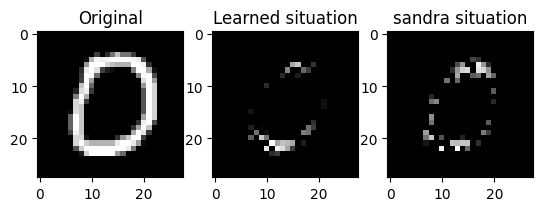

In [11]:
proj = model.mlp(x.reshape(-1, 784))
recon = model.back_mlp(proj).reshape(-1, 28, 28)
recon_s = model.back_mlp(situation).reshape(-1, 28, 28)

fig, axs = plt.subplots(1, 3)
axs[0].imshow(x[IDX, 0], cmap="gray")
axs[0].set_title("Original")

axs[1].imshow(recon[IDX].detach().cpu(), cmap="gray")
axs[1].set_title("Learned situation")

axs[2].imshow(recon_s[IDX].detach().cpu(), cmap="gray")
axs[2].set_title("sandra situation")
plt.show()

In [15]:
reasoner.device = "cpu"
inf = reasoner(proj)
inf_s = reasoner(situation)
pred = model.classifier(torch.cat([proj, inf], dim=1)).argmax(-1)

In [22]:
#torch.log(inf_s.T) 
#(torch.log(inf_s.T + 1e-5) * (torch.log(inf_s.T + 1e-5) - torch.log(inf.T + 1e-5))).min()

tensor(0., grad_fn=<MinBackward1>)

Pred tensor(0)
Target tensor(0)
Inferred situation: 
	 https://w3id.org/geometryofmeaning/digital-display/SegmentAOn
	 https://w3id.org/geometryofmeaning/digital-display/SegmentCOn
	 https://w3id.org/geometryofmeaning/digital-display/SegmentDOff
	 https://w3id.org/geometryofmeaning/digital-display/SegmentFOff
	 https://w3id.org/geometryofmeaning/digital-display/7SegmentNumber
Inferred descriptions
	 https://w3id.org/geometryofmeaning/digital-display/Number0  | Score:  0.2857142984867096
	 https://w3id.org/geometryofmeaning/digital-display/Number1  | Score:  0.4285714328289032
	 https://w3id.org/geometryofmeaning/digital-display/Number2  | Score:  0.2857142984867096
	 https://w3id.org/geometryofmeaning/digital-display/Number3  | Score:  0.4285714328289032
	 https://w3id.org/geometryofmeaning/digital-display/Number4  | Score:  0.2857142984867096
	 https://w3id.org/geometryofmeaning/digital-display/Number5  | Score:  0.2857142984867096
	 https://w3id.org/geometryofmeaning/digital-display/

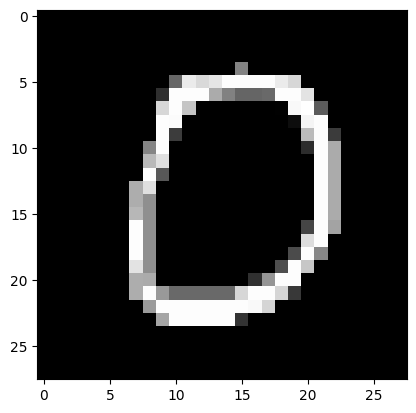

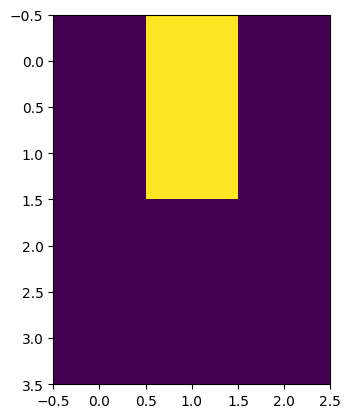

In [188]:
print("Pred", pred[IDX])
print("Target", y[IDX])

ort = F.normalize(proj) @ reasoner.basis.T
inferred_situation = [reasoner.ontology.elements[i] for i in torch.where(ort[IDX] > 0)[0]]
print("Inferred situation: \n\t", "\n\t ".join([str(e) for e in inferred_situation]))

print("Inferred descriptions")
for i, score in enumerate(inf[IDX]):
    print("\t", reasoner.ontology.descriptions[i].name, " | Score: ", score.item())

im = x[IDX, 0].reshape(28, 28)
plt.imshow(im, cmap="gray", vmin=0, vmax=1)
plt.show()

seven_seg = [1 if r in inferred_situation else 0 for r in reasoner.ontology.roles if "On" in r.name]
seven_seg = [0] + [seven_seg[0]] + [0] + seven_seg[1:5] + [0] + seven_seg[6:9] + [0] + [seven_seg[-1]] + [0]
plt.imshow(torch.tensor(seven_seg).reshape(4, 3))
plt.show()